## Mount Google Drive to access your data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
root_path = '/content/drive/MyDrive/COMP47590 Adv ML/10-monkey-species/'

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
from typing import Tuple, Dict, List
import random
import os

from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import cv2

In [4]:
# Set Device
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [5]:
random.seed(13204942)

## Image Loader and Viewer

In [6]:
from torch.utils.data import random_split

In [7]:
train_dir = f'{root_path}/training/training/'
test_dir = Path(f'{root_path}/validation/validation/')

In [8]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Test Images']
label_df = pd.read_csv(f"{root_path}/monkey_labels.txt", names=cols, skiprows=1)
label_df

,Label,Latin Name,Common Name,Train Images,Test Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [9]:
labels = label_df['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [10]:
num_classes = len(labels)

In [11]:
def image_show(label):
  num_image = 3
  columns = 3
  rows = 2
  fig = plt.figure(figsize=(15, 15))
  for i in range(1, columns*rows +1):
    imgdir = train_dir + label
    imgfile = random.choice(os.listdir(imgdir))
    img = cv2.imread(train_dir + label +'/'+ imgfile)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(imgfile)
  plt.show()

 pygmy_marmoset                


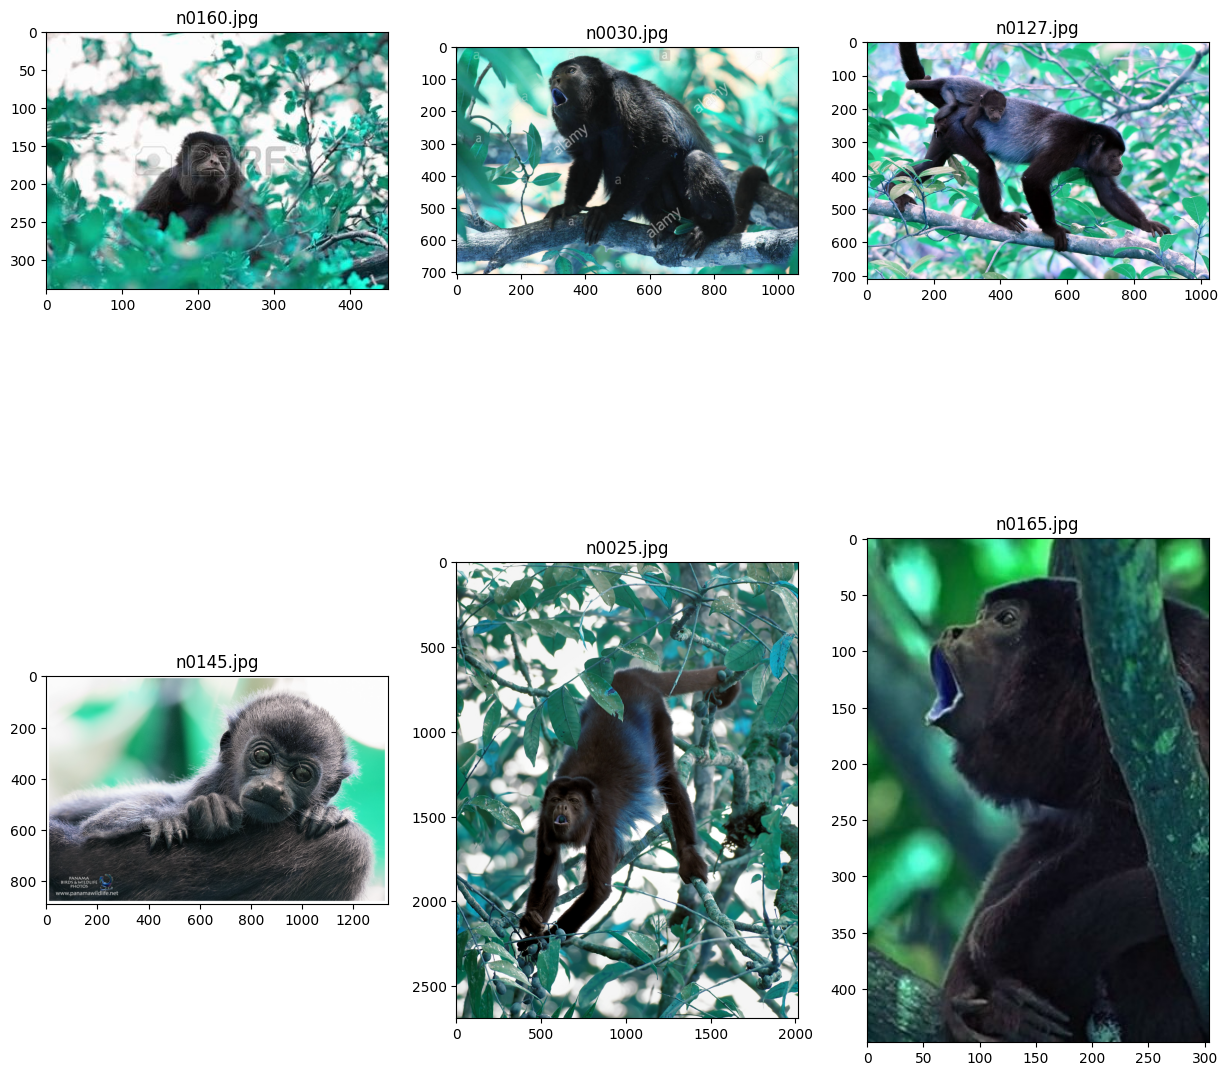

In [12]:
print(labels[4])
image_show('n0')

In [13]:
print(f"Number of training images {label_df['Train Images'].sum()}")
print(f"Number of validation images {label_df['Test Images'].sum()}")

Number of training images 1370
Number of validation images 272


## Create Datasets and DataLoaders

In [11]:
from torch import nn, utils, optim
import torchvision

In [12]:
# Define proportion of data for test, train and validation splits. 
train_split = 0.7
valid_split = 0.3

In [13]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [14]:
# Create Transforms
train_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(IMAGE_HEIGHT, IMAGE_WIDTH)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Test set does not need Transforms
test_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(IMAGE_HEIGHT, IMAGE_WIDTH)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [15]:
# Use ImageFolder to create dataset(s)
train_val_data = torchvision.datasets.ImageFolder(
    root=train_dir,
    transform=train_data_transform
)

test_data = torchvision.datasets.ImageFolder(
    root=test_dir, 
    transform=test_data_transform
)

Split the original training dataset with Train (70%) and Validation (30%)

In [16]:
train_size = int(train_split * len(train_val_data))
val_size = int(len(train_val_data) - train_size)

train_data, val_data = random_split(train_val_data, [train_size, val_size])

In [20]:
print(train_data)

In [21]:
print(test_data)

Dataset ImageFolder
    Number of datapoints: 272
    Root location: /content/drive/MyDrive/COMP47590 Adv ML/10-monkey-species/validation/validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


In [17]:
# Load dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [18]:
train_dataloader = utils.data.DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

val_dataloader = utils.data.DataLoader(
    dataset=val_data, 
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader = utils.data.DataLoader(
    dataset=test_data, 
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS, 
    shuffle=False
) 

In [19]:
# Get a batch and check shapes
image, label = next(iter(train_dataloader))

print(image.shape, label.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


## Build a Base LeCun CNN From Scratch

In [20]:
import torch.nn.functional as F

In [26]:
class LeCunNet(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
        nn.ReLU()
    )
    self.fc = nn.Sequential(
        nn.Linear(in_features=120 * 49 * 49, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=84),
        nn.ReLU()
    )
    self.classifier = nn.Linear(in_features=84, out_features=n_classes)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = x.reshape(x.size(0), -1)
    x = self.fc(x)

    logits = self.classifier(x)
    probs = F.softmax(logits, dim=1)

    return probs

In [21]:
from torchsummary import summary

In [65]:
model_LeCun = LeCunNet(len(labels)).to(DEVICE)

In [58]:
# Check model structure and parameters
print(summary(model_LeCun, (3, IMAGE_HEIGHT, IMAGE_WIDTH)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
              ReLU-2          [-1, 6, 220, 220]               0
         MaxPool2d-3          [-1, 6, 110, 110]               0
            Conv2d-4         [-1, 16, 106, 106]           2,416
              ReLU-5         [-1, 16, 106, 106]               0
         MaxPool2d-6           [-1, 16, 53, 53]               0
            Conv2d-7          [-1, 120, 49, 49]          48,120
              ReLU-8          [-1, 120, 49, 49]               0
            Linear-9                  [-1, 120]      34,574,520
             ReLU-10                  [-1, 120]               0
           Linear-11                   [-1, 84]          10,164
             ReLU-12                   [-1, 84]               0
           Linear-13                   [-1, 10]             850
Total params: 34,636,526
Trainable para

## Create A Training Function

In [22]:
from tqdm.auto import tqdm

In [23]:
def train_func(model, 
               train_dataloader, 
               valid_dataloader, 
               optimizer,
               loss_fn,
               epochs,
               device='cpu') -> Dict[str, List[float]]:
    
    # Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "valid_loss": [],
        "valid_acc": []
    }

    # Loop through training and validation steps for a number of epochs
    for epoch in tqdm(range(epochs)):
      # Put model in train mode
      model.train()
    
      # Setup train loss and train accuracy values
      train_loss, train_acc = 0, 0
    
      # Loop through data loader data batches
      for batch, (X, y) in enumerate(train_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Adjust metrics to get average loss and accuracy per batch 
      train_loss = train_loss / len(train_dataloader)
      train_acc = train_acc / len(train_dataloader)

      # Put model in eval mode
      model.eval() 
      valid_pred = []
      valid_true = []
  
      # Setup valid loss and valid accuracy values
      valid_loss, valid_acc = 0, 0
  
      # Turn on inference context manager
      with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(valid_dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)
          valid_true.extend(y)

          # 1. Forward pass
          valid_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(valid_pred_logits, y)
          valid_loss += loss.item()

          # Calculate and accumulate accuracy
          valid_pred_labels = valid_pred_logits.argmax(dim=1)
          valid_pred.extend(valid_pred_labels)
          
          valid_acc += ((valid_pred_labels == y).sum().item()/len(valid_pred_labels))
          
      # Adjust metrics to get average loss and accuracy per batch 
      valid_loss = valid_loss / len(valid_dataloader)
      valid_acc = valid_acc / len(valid_dataloader)    

      # Print out what's happening
      print(f"Epoch: {epoch+1} | ",
            f"train_loss: {train_loss:.4f} | ",
            f"train_acc: {train_acc:.4f} | ",
            f"valid_loss: {valid_loss:.4f} | ",
            f"valid_acc: {valid_acc:.4f}"
            )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["valid_loss"].append(valid_loss)
      results["valid_acc"].append(valid_acc)

    # Return the filled results at the end of the epochs
    return results, valid_true, valid_pred

## Start Training

In [24]:
EPOCHS = 50
LEARNING_RATE = 5e-4
# Set loss and optimizer
loss_fn = nn.CrossEntropyLoss()

### Train a LeCun Model

In [67]:
# Set a Adam optimizer
optimizer = torch.optim.Adam(params=model_LeCun.parameters(), lr=LEARNING_RATE)

In [68]:
# start training
results_LeCun, lecun_y_true, lecun_y_pred = train_func(model = model_LeCun, 
                           train_dataloader = train_dataloader, 
                           valid_dataloader = val_dataloader, 
                           optimizer = optimizer,
                           loss_fn = loss_fn,
                           epochs = EPOCHS,
                           device = DEVICE)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 |  train_loss: 2.2360 |  train_acc: 0.1917 |  valid_loss: 2.1950 |  valid_acc: 0.2563
Epoch: 2 |  train_loss: 2.1364 |  train_acc: 0.3167 |  valid_loss: 2.1665 |  valid_acc: 0.2920
Epoch: 3 |  train_loss: 2.1243 |  train_acc: 0.3234 |  valid_loss: 2.1429 |  valid_acc: 0.3267
Epoch: 4 |  train_loss: 2.1269 |  train_acc: 0.3390 |  valid_loss: 2.0985 |  valid_acc: 0.3574
Epoch: 5 |  train_loss: 2.0911 |  train_acc: 0.3740 |  valid_loss: 2.1816 |  valid_acc: 0.2733
Epoch: 6 |  train_loss: 2.2405 |  train_acc: 0.2150 |  valid_loss: 2.2495 |  valid_acc: 0.2034
Epoch: 7 |  train_loss: 2.1845 |  train_acc: 0.2701 |  valid_loss: 2.1828 |  valid_acc: 0.2727
Epoch: 8 |  train_loss: 2.1221 |  train_acc: 0.3311 |  valid_loss: 2.1501 |  valid_acc: 0.2972
Epoch: 9 |  train_loss: 2.0808 |  train_acc: 0.3703 |  valid_loss: 2.1214 |  valid_acc: 0.3335
Epoch: 10 |  train_loss: 2.0166 |  train_acc: 0.4371 |  valid_loss: 2.0574 |  valid_acc: 0.3915
Epoch: 11 |  train_loss: 1.9932 |  train_acc: 0.4

#### Visualization of Loss

In [69]:
# Get all results and convert it to dataframe
results_LeCun = pd.DataFrame(results_LeCun)

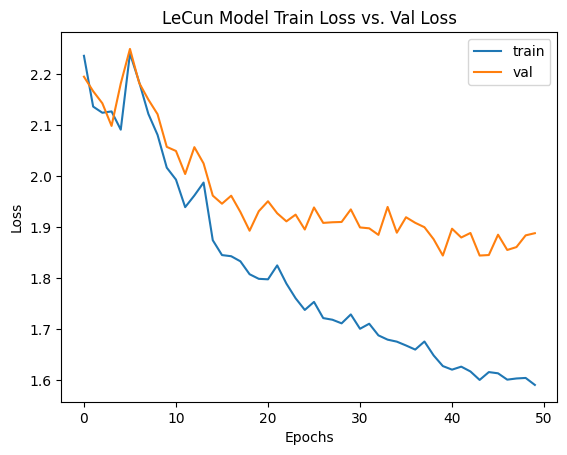

In [70]:
# Visualize the losses
results_LeCun['train_loss'].plot(label='train')
results_LeCun['valid_loss'].plot(label='val')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LeCun Model Train Loss vs. Val Loss")
plt.legend()
plt.show();

#### Evaluate the LeCun Model on Test Set

In [25]:
from sklearn import metrics

In [79]:
X_test_monkey = []
y_true = []
y_pred = []

for i, (X_test, y_test) in enumerate(test_dataloader):
  # Send data to target device
  X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

  test_outputs = model_LeCun(X_test)
  _, preds = torch.max(test_outputs, 1)

  # Add up the predictions
  X_test_monkey.extend(X_test)
  y_true.extend(y_test.cpu())
  y_pred.extend(preds.cpu())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
# Print performance details
print(metrics.classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.61      0.54      0.57        26
           1       0.44      0.43      0.44        28
           2       0.69      0.74      0.71        27
           3       0.54      0.73      0.62        30
           4       0.44      0.46      0.45        26
           5       0.47      0.32      0.38        28
           6       0.44      0.73      0.55        26
           7       0.58      0.50      0.54        28
           8       0.63      0.70      0.67        27
           9       0.56      0.19      0.29        26

    accuracy                           0.54       272
   macro avg       0.54      0.54      0.52       272
weighted avg       0.54      0.54      0.52       272



In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

<Axes: >

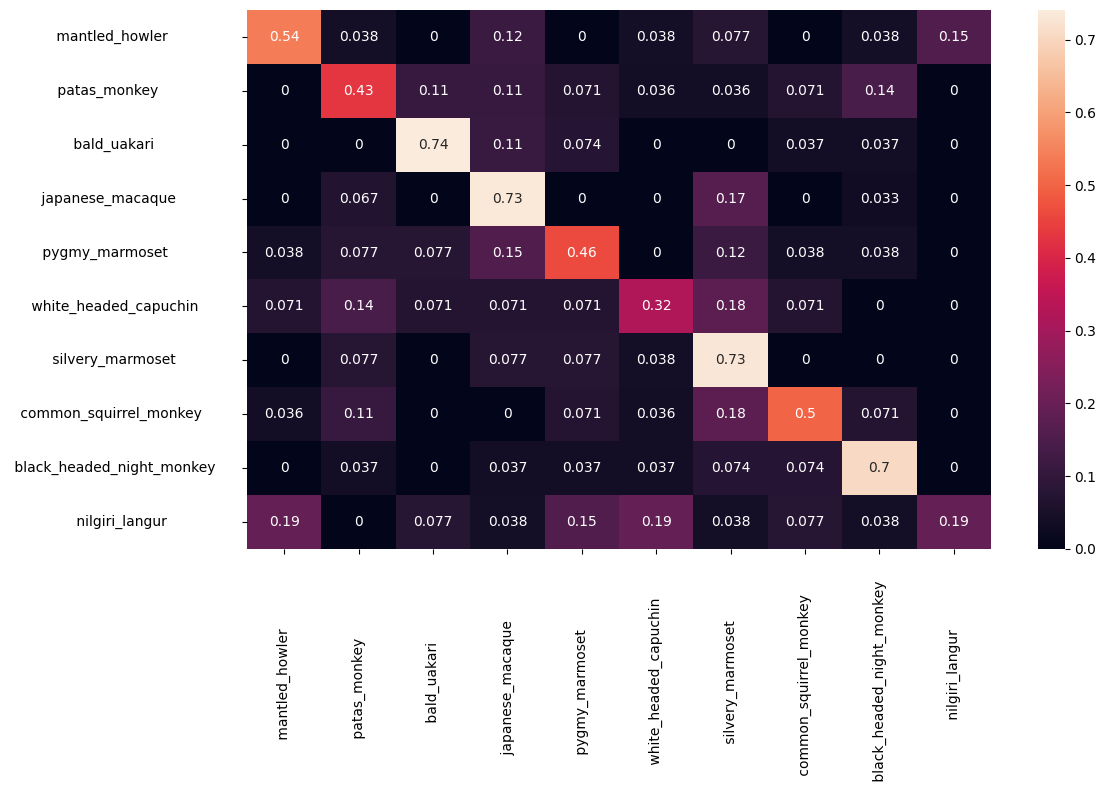

In [83]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

### Build and Train a VGG-16 Model

In [39]:
from torchvision.models import vgg16, VGG16_Weights

In [40]:
# Define a VGG-16 model
model = vgg16(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Freeze the weights of the pre-trained layers

In [41]:
for param in model.parameters():
    param.requires_grad = False

In [42]:
# Get the input size of the fully connected layer
input_size = model.classifier[0].in_features
input_size

25088

Replace the fully connected layers

In [43]:
model.classifier = nn.Sequential(
    nn.Linear(input_size, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

In [44]:
model = model.to(DEVICE)

In [34]:
summary(model, (3, IMAGE_HEIGHT, IMAGE_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [45]:
EPOCHS = 15
LEARNING_RATE = 1e-3

In [46]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [47]:
# start training
results, vgg_y_true, vgg_y_pred  = train_func(model = model, 
                                              train_dataloader = train_dataloader, 
                                              valid_dataloader = val_dataloader, 
                                              optimizer = optimizer,
                                              loss_fn = loss_fn,
                                              epochs = EPOCHS,
                                              device = DEVICE)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 |  train_loss: 5.7785 |  train_acc: 0.5207 |  valid_loss: 0.2930 |  valid_acc: 0.8943
Epoch: 2 |  train_loss: 0.3438 |  train_acc: 0.9022 |  valid_loss: 0.2439 |  valid_acc: 0.9284
Epoch: 3 |  train_loss: 0.3145 |  train_acc: 0.9205 |  valid_loss: 0.1845 |  valid_acc: 0.9545
Epoch: 4 |  train_loss: 0.2917 |  train_acc: 0.9361 |  valid_loss: 0.3666 |  valid_acc: 0.9284
Epoch: 5 |  train_loss: 0.2666 |  train_acc: 0.9453 |  valid_loss: 0.4834 |  valid_acc: 0.9398
Epoch: 6 |  train_loss: 0.2988 |  train_acc: 0.9531 |  valid_loss: 0.5547 |  valid_acc: 0.9403
Epoch: 7 |  train_loss: 0.3382 |  train_acc: 0.9440 |  valid_loss: 0.6467 |  valid_acc: 0.9233
Epoch: 8 |  train_loss: 0.5353 |  train_acc: 0.9362 |  valid_loss: 1.5029 |  valid_acc: 0.8392
Epoch: 9 |  train_loss: 0.7477 |  train_acc: 0.9348 |  valid_loss: 0.8814 |  valid_acc: 0.9034
Epoch: 10 |  train_loss: 0.7861 |  train_acc: 0.9426 |  valid_loss: 0.6444 |  valid_acc: 0.9256
Epoch: 11 |  train_loss: 0.5353 |  train_acc: 0.9

#### Visualization of Loss

In [48]:
# Get all results and convert it to dataframe
results = pd.DataFrame(results)

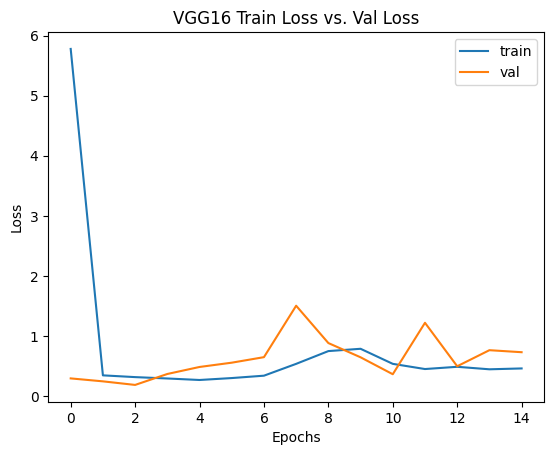

In [49]:
# Visualize the losses
results['train_loss'].plot(label='train')
results['valid_loss'].plot(label='val')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("VGG16 Train Loss vs. Val Loss")
plt.legend()
plt.show();

#### Evaluate the VGG Model on Test Set

In [50]:
X_test_vgg_monkey = []
y_true_vgg = []
y_pred_vgg = []

for i, (X_test, y_test) in enumerate(test_dataloader):
  # Send data to target device
  X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

  test_outputs = model(X_test)
  _, preds = torch.max(test_outputs, 1)

  # Add up the predictions
  X_test_vgg_monkey.extend(X_test)
  y_true_vgg.extend(y_test.cpu())
  y_pred_vgg.extend(preds.cpu())

y_true_vgg = np.array(y_true_vgg)
y_pred_vgg = np.array(y_pred_vgg)
# Print performance details
print(metrics.classification_report(y_true_vgg, y_pred_vgg))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       1.00      1.00      1.00        28
           2       0.96      1.00      0.98        27
           3       1.00      0.90      0.95        30
           4       0.96      1.00      0.98        26
           5       1.00      0.96      0.98        28
           6       1.00      0.96      0.98        26
           7       0.93      1.00      0.97        28
           8       1.00      0.96      0.98        27
           9       0.90      1.00      0.95        26

    accuracy                           0.97       272
   macro avg       0.98      0.98      0.97       272
weighted avg       0.98      0.97      0.97       272



<Axes: >

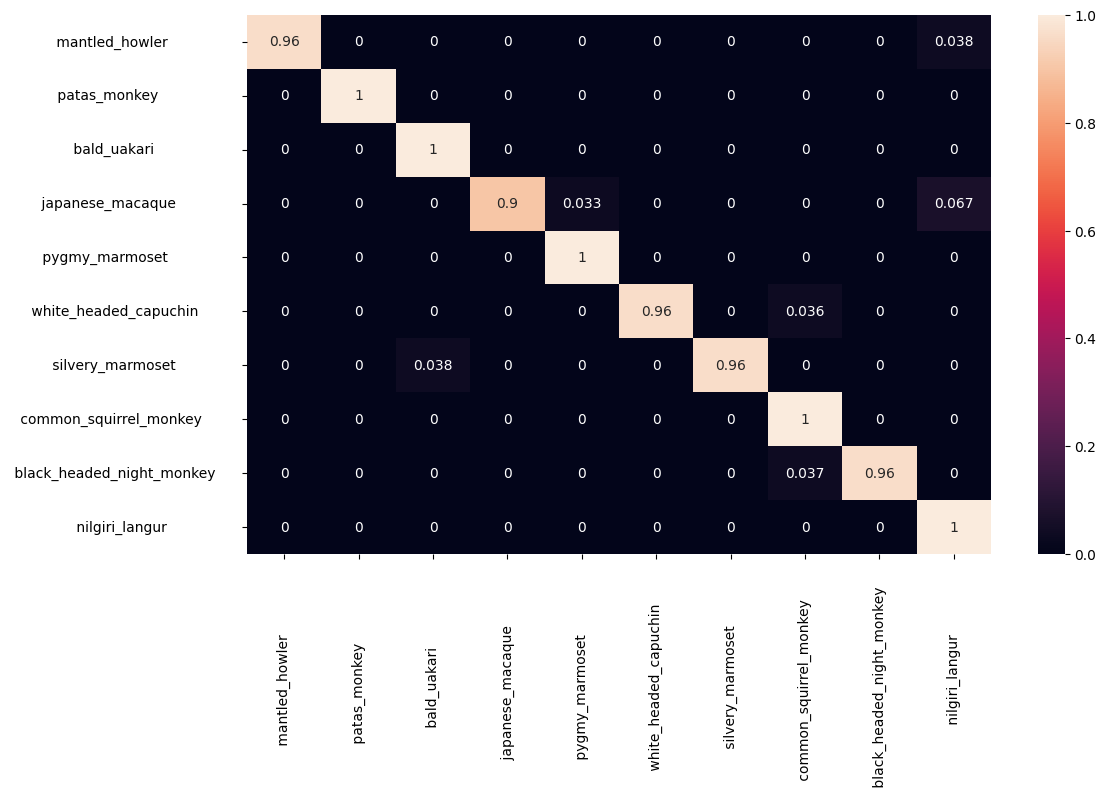

In [51]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true_vgg, y_pred_vgg)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

## Discussion

* The LeCun CNN model created by ourselves nearly coveraged after 50 epoches, but the pre-trained VGG-16 model converaged much quicker at the first 5 epoches. 
* The results of validation show that VGG-16 model outperformed our own LeCun model, because VGG-16 reached higher accuracy.
* The size of the LeCun model is much less than VGG-16.
* The Confusion Matrix of testing indicates that VGG-16 performs so well on this monkey classification task and it is better than the LeCun model. Our LeCun model only achieved 0.54 F1 score.